In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [3]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [4]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [5]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False

In [6]:
class FCN32(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN32, self).__init__()
        self.vgg16 = vgg16.features
        # self.conv1 = self.make_block(in_channel=3, out_channel=64,repeat=2)
        # self.conv2 = self.make_block(in_channel=64,out_channel=128,repeat=2)
        # self.conv3 = self.make_block(128,256,3)
        # self.conv4 = self.make_block(256,512,3)
        # self.conv5 = self.make_block(512,512,3)

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)

        self.upsample32 = nn.ConvTranspose2d(num_class,num_class,kernel_size=32,stride=32)
        #self.upsample32 = nn.Upsample(scale_factor=32,mode='bilinear')
        #self._initialize_weights()

    def forward(self, x):

        x = self.vgg16(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc3(x)
        x = self.upsample32(x)
        #print(x.shape)
        return x
        

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         print(m)
    #         if isinstance(m, nn.Conv2d):
    #             m.weight.data.zero_()
    #             if m.bias is not None:
    #                 m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [7]:
FCN =FCN32(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.00005)

In [9]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [10]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN32-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:28, 12.90it/s]
363it [00:23, 15.37it/s]


1 epcoh , time = 52.00
train loss : 1.38889, val_loss : 1.13061
train IoU : 0.12603, val IoU : 0.13172
train Acc : 0.72404, val Acc : 0.74737


366it [00:27, 13.49it/s]
363it [00:23, 15.53it/s]


2 epcoh , time = 50.51
train loss : 1.10291, val_loss : 1.09741
train IoU : 0.12836, val IoU : 0.12924
train Acc : 0.74891, val Acc : 0.74766


366it [00:27, 13.31it/s]
363it [00:23, 15.29it/s]


3 epcoh , time = 51.25
train loss : 1.07922, val_loss : 1.06984
train IoU : 0.13023, val IoU : 0.13585
train Acc : 0.74912, val Acc : 0.74876


366it [00:26, 13.90it/s]
363it [00:23, 15.30it/s]


4 epcoh , time = 50.06
train loss : 0.99872, val_loss : 0.96155
train IoU : 0.15645, val IoU : 0.16568
train Acc : 0.75678, val Acc : 0.75280


366it [00:28, 12.74it/s]
363it [00:23, 15.55it/s]


5 epcoh , time = 52.09
train loss : 0.84980, val_loss : 0.81660
train IoU : 0.20485, val IoU : 0.23148
train Acc : 0.77368, val Acc : 0.78264


366it [00:27, 13.11it/s]
363it [00:23, 15.56it/s]


6 epcoh , time = 51.26
train loss : 0.75280, val_loss : 0.75511
train IoU : 0.26305, val IoU : 0.25459
train Acc : 0.79324, val Acc : 0.79190


366it [00:27, 13.27it/s]
363it [00:23, 15.23it/s]


7 epcoh , time = 51.43
train loss : 0.68687, val_loss : 0.71702
train IoU : 0.29256, val IoU : 0.27751
train Acc : 0.80551, val Acc : 0.79866


366it [00:28, 13.05it/s]
363it [00:24, 14.98it/s]


8 epcoh , time = 52.29
train loss : 0.64448, val_loss : 0.69603
train IoU : 0.31467, val IoU : 0.29506
train Acc : 0.81245, val Acc : 0.80000


366it [00:27, 13.23it/s]
363it [00:23, 15.14it/s]


9 epcoh , time = 51.64
train loss : 0.61670, val_loss : 0.66785
train IoU : 0.32430, val IoU : 0.32466
train Acc : 0.81764, val Acc : 0.81093


366it [00:27, 13.22it/s]
363it [00:23, 15.35it/s]


10 epcoh , time = 51.36
train loss : 0.58950, val_loss : 0.66041
train IoU : 0.34067, val IoU : 0.32700
train Acc : 0.82379, val Acc : 0.81084


366it [00:28, 12.84it/s]
363it [00:23, 15.15it/s]


11 epcoh , time = 52.46
train loss : 0.56183, val_loss : 0.65128
train IoU : 0.35485, val IoU : 0.33138
train Acc : 0.82928, val Acc : 0.81213


366it [00:27, 13.36it/s]
363it [00:24, 14.83it/s]


12 epcoh , time = 51.88
train loss : 0.53680, val_loss : 0.64191
train IoU : 0.37501, val IoU : 0.32733
train Acc : 0.83635, val Acc : 0.81385


366it [00:27, 13.40it/s]
363it [00:23, 15.44it/s]


13 epcoh , time = 50.83
train loss : 0.52237, val_loss : 0.63708
train IoU : 0.38011, val IoU : 0.34541
train Acc : 0.83770, val Acc : 0.81811


366it [00:27, 13.45it/s]
363it [00:25, 14.35it/s]


14 epcoh , time = 52.51
train loss : 0.49942, val_loss : 0.62246
train IoU : 0.39321, val IoU : 0.36355
train Acc : 0.84467, val Acc : 0.82049


366it [00:27, 13.14it/s]
363it [00:24, 15.10it/s]


15 epcoh , time = 51.91
train loss : 0.48329, val_loss : 0.62763
train IoU : 0.40767, val IoU : 0.35578
train Acc : 0.84841, val Acc : 0.81977


366it [00:27, 13.20it/s]
363it [00:24, 14.86it/s]


16 epcoh , time = 52.15
train loss : 0.47106, val_loss : 0.62974
train IoU : 0.41368, val IoU : 0.35963
train Acc : 0.85186, val Acc : 0.82071


366it [00:28, 13.01it/s]
363it [00:24, 14.80it/s]


17 epcoh , time = 52.67
train loss : 0.45209, val_loss : 0.63332
train IoU : 0.42495, val IoU : 0.36038
train Acc : 0.85601, val Acc : 0.82204


366it [00:27, 13.24it/s]
363it [00:24, 14.87it/s]


18 epcoh , time = 52.07
train loss : 0.43548, val_loss : 0.63105
train IoU : 0.43009, val IoU : 0.36087
train Acc : 0.86023, val Acc : 0.82151


366it [00:28, 13.04it/s]
363it [00:23, 15.34it/s]


19 epcoh , time = 51.74
train loss : 0.41968, val_loss : 0.63481
train IoU : 0.44396, val IoU : 0.35857
train Acc : 0.86389, val Acc : 0.82060


366it [00:27, 13.21it/s]
363it [00:24, 14.93it/s]


20 epcoh , time = 52.02
train loss : 0.40234, val_loss : 0.62949
train IoU : 0.45447, val IoU : 0.37412
train Acc : 0.86865, val Acc : 0.82098


366it [00:27, 13.13it/s]
363it [00:23, 15.41it/s]


21 epcoh , time = 51.44
train loss : 0.38955, val_loss : 0.63911
train IoU : 0.46308, val IoU : 0.37666
train Acc : 0.87149, val Acc : 0.82366


366it [00:28, 12.89it/s]
363it [00:24, 14.88it/s]


22 epcoh , time = 52.78
train loss : 0.37977, val_loss : 0.64587
train IoU : 0.47449, val IoU : 0.37670
train Acc : 0.87468, val Acc : 0.82170


366it [00:28, 12.98it/s]
363it [00:24, 14.81it/s]


23 epcoh , time = 52.72
train loss : 0.36627, val_loss : 0.64835
train IoU : 0.48349, val IoU : 0.37337
train Acc : 0.87817, val Acc : 0.82041


366it [00:28, 12.95it/s]
363it [00:23, 15.25it/s]


24 epcoh , time = 52.08
train loss : 0.35360, val_loss : 0.65397
train IoU : 0.48786, val IoU : 0.38273
train Acc : 0.88174, val Acc : 0.82208


366it [00:26, 13.65it/s]
363it [00:24, 14.56it/s]


25 epcoh , time = 51.75
train loss : 0.34098, val_loss : 0.67991
train IoU : 0.49852, val IoU : 0.38291
train Acc : 0.88513, val Acc : 0.82115


366it [00:28, 12.67it/s]
363it [00:24, 14.95it/s]


26 epcoh , time = 53.18
train loss : 0.33172, val_loss : 0.66795
train IoU : 0.50710, val IoU : 0.36833
train Acc : 0.88808, val Acc : 0.81727


366it [00:29, 12.23it/s]
363it [00:23, 15.58it/s]


27 epcoh , time = 53.23
train loss : 0.32098, val_loss : 0.67102
train IoU : 0.51375, val IoU : 0.38398
train Acc : 0.89125, val Acc : 0.81864


366it [00:28, 12.75it/s]
363it [00:23, 15.31it/s]


28 epcoh , time = 52.43
train loss : 0.31421, val_loss : 0.67306
train IoU : 0.51876, val IoU : 0.38953
train Acc : 0.89186, val Acc : 0.82019


366it [00:28, 12.96it/s]
363it [00:23, 15.52it/s]


29 epcoh , time = 51.64
train loss : 0.30531, val_loss : 0.68573
train IoU : 0.52625, val IoU : 0.38609
train Acc : 0.89592, val Acc : 0.82411


366it [00:27, 13.41it/s]
363it [00:23, 15.17it/s]


30 epcoh , time = 51.22
train loss : 0.29854, val_loss : 0.68774
train IoU : 0.53679, val IoU : 0.39157
train Acc : 0.89728, val Acc : 0.82112


366it [00:28, 12.85it/s]
363it [00:23, 15.69it/s]


31 epcoh , time = 51.62
train loss : 0.28849, val_loss : 0.70973
train IoU : 0.53559, val IoU : 0.37586
train Acc : 0.90053, val Acc : 0.82156


366it [00:27, 13.21it/s]
363it [00:24, 15.02it/s]


32 epcoh , time = 51.89
train loss : 0.28256, val_loss : 0.71324
train IoU : 0.54292, val IoU : 0.37556
train Acc : 0.90205, val Acc : 0.82305


366it [00:28, 12.90it/s]
363it [00:23, 15.20it/s]


33 epcoh , time = 52.27
train loss : 0.27831, val_loss : 0.69843
train IoU : 0.55001, val IoU : 0.37835
train Acc : 0.90257, val Acc : 0.81775


366it [00:29, 12.52it/s]
363it [00:24, 14.75it/s]


34 epcoh , time = 53.85
train loss : 0.27069, val_loss : 0.71318
train IoU : 0.55387, val IoU : 0.39862
train Acc : 0.90535, val Acc : 0.81619


366it [00:27, 13.37it/s]
363it [00:24, 15.03it/s]


35 epcoh , time = 51.54
train loss : 0.26488, val_loss : 0.72926
train IoU : 0.55530, val IoU : 0.38354
train Acc : 0.90666, val Acc : 0.82145


366it [00:29, 12.61it/s]
363it [00:24, 15.12it/s]


36 epcoh , time = 53.04
train loss : 0.25967, val_loss : 0.72760
train IoU : 0.56028, val IoU : 0.39199
train Acc : 0.90830, val Acc : 0.82053


366it [00:27, 13.23it/s]
363it [00:24, 14.85it/s]


37 epcoh , time = 52.11
train loss : 0.25502, val_loss : 0.72687
train IoU : 0.56359, val IoU : 0.39644
train Acc : 0.90941, val Acc : 0.81849


366it [00:28, 13.05it/s]
363it [00:24, 14.73it/s]


38 epcoh , time = 52.70
train loss : 0.24877, val_loss : 0.74026
train IoU : 0.56957, val IoU : 0.38211
train Acc : 0.91164, val Acc : 0.82387


366it [00:27, 13.25it/s]
363it [00:24, 14.75it/s]


39 epcoh , time = 52.23
train loss : 0.24197, val_loss : 0.77823
train IoU : 0.57483, val IoU : 0.37806
train Acc : 0.91370, val Acc : 0.82410


366it [00:28, 12.93it/s]
363it [00:25, 14.30it/s]


40 epcoh , time = 53.71
train loss : 0.23841, val_loss : 0.78347
train IoU : 0.57670, val IoU : 0.38204
train Acc : 0.91454, val Acc : 0.82410


366it [00:27, 13.14it/s]
363it [00:23, 15.29it/s]


41 epcoh , time = 51.61
train loss : 0.23520, val_loss : 0.76182
train IoU : 0.58198, val IoU : 0.38165
train Acc : 0.91492, val Acc : 0.82250


366it [00:28, 12.76it/s]
363it [00:25, 14.23it/s]


42 epcoh , time = 54.18
train loss : 0.23205, val_loss : 0.76936
train IoU : 0.58106, val IoU : 0.39305
train Acc : 0.91610, val Acc : 0.82125


366it [00:27, 13.10it/s]
363it [00:24, 14.68it/s]


43 epcoh , time = 52.67
train loss : 0.22753, val_loss : 0.77842
train IoU : 0.59026, val IoU : 0.39230
train Acc : 0.91737, val Acc : 0.81949


366it [00:28, 12.97it/s]
363it [00:24, 14.85it/s]


44 epcoh , time = 52.67
train loss : 0.22313, val_loss : 0.77260
train IoU : 0.59365, val IoU : 0.38718
train Acc : 0.91874, val Acc : 0.82203


366it [00:27, 13.33it/s]
363it [00:24, 14.69it/s]


45 epcoh , time = 52.18
train loss : 0.22041, val_loss : 0.79937
train IoU : 0.59049, val IoU : 0.39146
train Acc : 0.91921, val Acc : 0.82140


366it [00:28, 13.02it/s]
363it [00:26, 13.88it/s]


46 epcoh , time = 54.26
train loss : 0.21883, val_loss : 0.79312
train IoU : 0.59616, val IoU : 0.39615
train Acc : 0.91956, val Acc : 0.82162


366it [00:28, 13.06it/s]
363it [00:24, 14.91it/s]


47 epcoh , time = 52.39
train loss : 0.21285, val_loss : 0.80403
train IoU : 0.60132, val IoU : 0.38442
train Acc : 0.92149, val Acc : 0.82175


366it [00:27, 13.37it/s]
363it [00:25, 14.23it/s]


48 epcoh , time = 52.90
train loss : 0.21146, val_loss : 0.79903
train IoU : 0.60098, val IoU : 0.38869
train Acc : 0.92157, val Acc : 0.82407


366it [00:28, 12.84it/s]
363it [00:25, 14.26it/s]


49 epcoh , time = 53.98
train loss : 0.20913, val_loss : 0.80748
train IoU : 0.60778, val IoU : 0.39160
train Acc : 0.92263, val Acc : 0.82217


366it [00:27, 13.22it/s]
363it [00:19, 18.96it/s]

50 epcoh , time = 46.84
train loss : 0.20454, val_loss : 0.81671
train IoU : 0.60726, val IoU : 0.38457
train Acc : 0.92390, val Acc : 0.82633
Finish Training


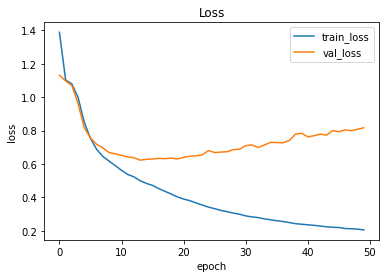

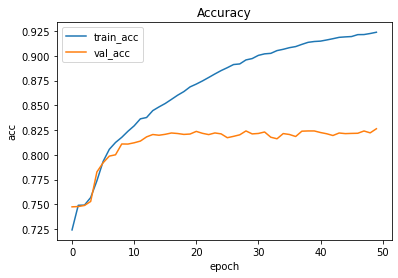

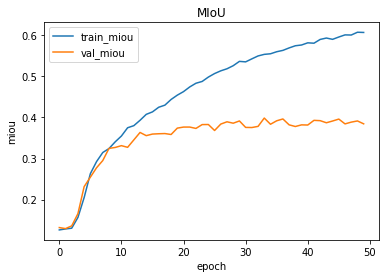

In [11]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [12]:
best=torch.load('./models/FCN32-Vgg16.pt')

In [13]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

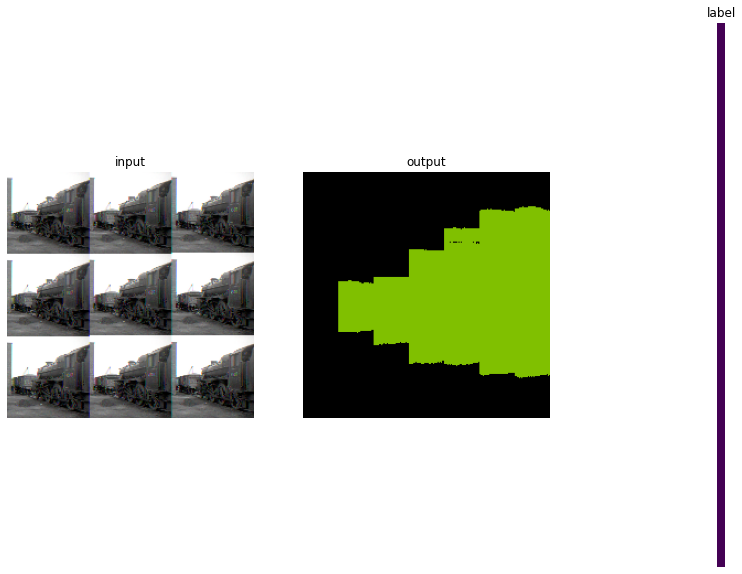

In [14]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.reshape(img.shape[1], img.shape[2], img.shape[0])

        label = decode_segmap(label[0],21)

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label[0])
        break
